#Billedeklassificering med K-nearest neighbor
I denne notebook skal vi arbejde med billedeklassificering vha. af nearest neighbor algoritmen som vi netop har hørt om. Formålet med denne øvelse er at lære hvordan man arbejder med udvikling/træning af klassificeringsmodeller til bla. billeder.

K-nearest neighbor algoritmen har nogle helt åbentlyse svagheder når til kommer til netop billedeklassificering. Algoritmen er en af de tidligste eksempler på "machine learning" som blev introduceret af Evelyn Fix and Joseph Hodges i 1951. Ikke desto mindre er det en god introduktion til machine learning modeller, og hvordan man på den korrekte måde arbejder med udvikling af disse. Senere, når vi skal se på neurale netværk, vil denne notebook også understrege den udvikling der er sket inden for billedeklassificeringsfeltet.

#Datasættet
Data som anvendes i denne notebook er "BloodMNIST" datasættet som kommer fra [MedMNIST databasen](https://medmnist.com/)

#Beskrivelse fra oprindelig kilde:
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set.

Billederne er tilgængelige i forskellige opløsninger 28x28, 64x64, 128x128,og 224x224 med 3 kanaler (RGB). I denne notebook arbejder vi med billeder i opløsning 28x28x3. De 8 forskellige klasser er:

['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


Angivet kategorisk med værdierne:

[0, 1, 2, 3, 4, 5, 6, 7]

Nedenfor downloades og importeres datasættet og opdeles i separate trænings- og valideringssæt (tuning) og nogle eksempler illustreres.


In [ ]:
%pip install medmnist
import medmnist

from medmnist import BloodMNIST
trainDataset = BloodMNIST(split="train", download=True,size=28)
valDataset = BloodMNIST(split="val", download=True,size=28)


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


Træningsdata:
Billeder: (11959, 28, 28, 3), Labels: (11959, 1)
Valideringsdata:
Billeder: (1712, 28, 28, 3), Labels: (1712, 1)


plot nogle eksempler:
klasse: 0, klassenavn: basophil. Antal træning samples: 852
klasse: 1, klassenavn: eosinophil. Antal træning samples: 2181
klasse: 2, klassenavn: erythroblast. Antal træning samples: 1085
klasse: 3, klassenavn: immature granulocytes(myelocytes, metamyelocytes and promyelocytes). Antal træning samples: 2026
klasse: 4, klassenavn: lymphocyte. Antal træning samples: 849
klasse: 5, klassenavn: monocyte. Antal træning samples: 993
klasse: 6, klassenavn: neutrophil. Antal træning samples: 2330
klasse: 7, klassenavn: platelet. Antal træning samples: 1643


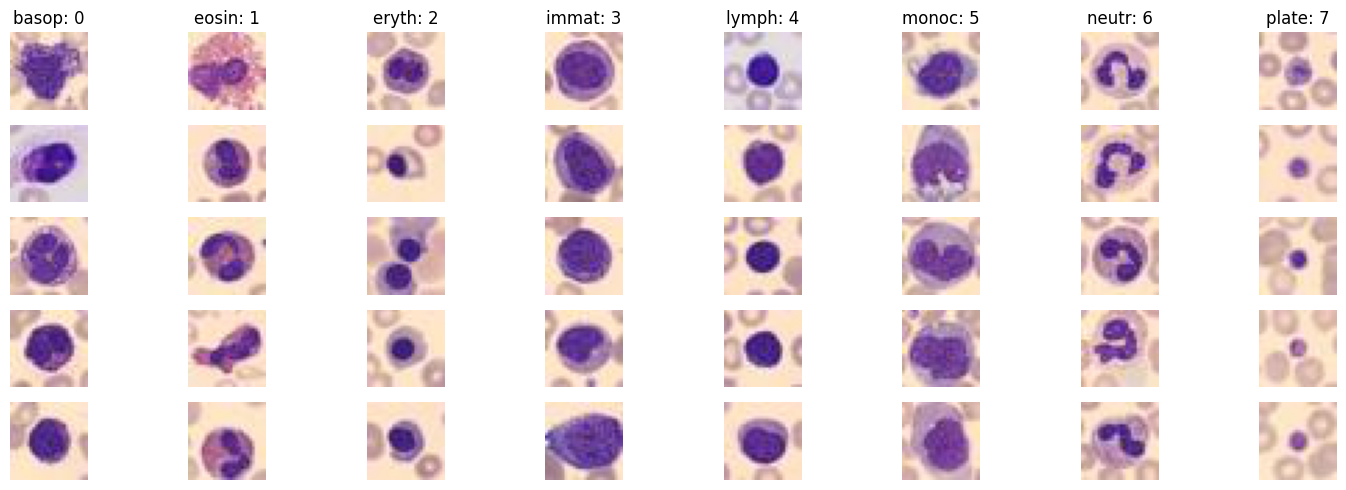

In [ ]:

trainImages,trainLabels,trainInfo = trainDataset.__dict__['imgs'],trainDataset.__dict__['labels'],trainDataset.__dict__['info']['label']


print('Træningsdata:')
print(f'Billeder: {trainImages.shape}, Labels: {trainLabels.shape}')


valImages,valLabels = valDataset.__dict__['imgs'],valDataset.__dict__['labels']
print('Valideringsdata:')
print(f'Billeder: {valImages.shape}, Labels: {valLabels.shape}')

import matplotlib.pyplot as plt
import random

print('\n')
print('plot nogle eksempler:')

random.seed(42)
fig, axes = plt.subplots(5, len(trainInfo), figsize=(15, 5))

for class_,name in trainInfo.items():
    print(f'klasse: {class_}, klassenavn: {name}. Antal træning samples: {len(trainLabels[trainLabels==int(class_)])}')
    # Get indices of all images belonging to class i
    class_indices = [idx for idx, label in enumerate(trainLabels) if int(class_) == label]
    # Randomly select 5 indices
    selected_indices = random.sample(class_indices, 5)
    for j, idx in enumerate(selected_indices):
        image, label = trainImages[idx],trainLabels[idx]
        axes[j, int(class_)].imshow(image, cmap='gray')
        axes[j, int(class_)].axis('off')
        if j == 0:
            axes[j, int(class_)].set_title(f'{name[:5]}: {class_}')

plt.tight_layout()
plt.show()

Som det fremgår af ovenstående, så arbejder vi her med et datasæt, som for det første er relativt homogent i forhold til udseende af de forskellige klasser, og ubalanceret. Dvs. der er eksempelvis væsentligt flere samples af neutrophil klassen end af basophilklassen. Begge ting vil gør det udfordrende at løse klassificeringsproblemet, både i denne notebook, men også når vi arbejder med andre modeller.

Nedenfor uderfører vi lidt preprocessring af data for at gøre det mere håndterbart i denne notebok.

In [ ]:
import numpy as np

#set random seed for reproducibility
np.random.seed(0)

#Shuffle the data
randomize = np.arange(trainImages.shape[0])
np.random.shuffle(randomize)

X_train = trainImages[randomize]
y_train = trainLabels[randomize].flatten()

randomizeVal = np.arange(valImages.shape[0])
X_val = valImages[randomizeVal]
y_val = valLabels[randomizeVal].flatten()


# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))

X_train = X_train[mask]
y_train = y_train[mask]

print('first 10 examples in train: ',y_train[:10])

num_val = 500
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

print('first 10 examples in val: ',y_val[:10])

# Reshape the image data into rows for effecient distance calculation
#(vi tager billedet med dimensioner 28x28x3 og strækker det ud til en vektor med længden 28*28*3 = 2352)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
print(f'New train shape: {X_train.shape}')
print(f'New val shape: {X_val.shape}')


first 10 examples in train:  [1 0 2 7 7 4 3 0 4 7]
first 10 examples in val:  [4 0 7 6 1 6 1 7 6 5]
New train shape: (5000, 2352)
New val shape: (500, 2352)


#K-nearest neighbor algoritmen
Neden for implementeres selve modellen. En kNN model er en "lazy learner". Dvs. selve træningsfunktionen egentlig blot gemmer data (træningsbilleder + labels) til reference.

En implementering af kNN algoritmen ville forventes at være udstyret med en funktion til "træning" hvor modellen gemmer blot træningsdata til sammenligning. En funktion som beregner afstand fra test/validerings eksempler til træningseksempler vha. af en given metrik (eksempelvis euclidian distance), og en funktion til at lave prediktioner på baggrund af de k nærmeste naboer Repræsenteret i psudokode nedenfor.


    class  KNearestNeighbor:

      Method __init__():
          Initialize the classifier

      Method train(X_train, y_train):
          Store the training data X_train and labels y_train

      Method calculate_distances(X_test):
          Initialize distance matrix
          For each test point in X_test:
              For each training point in X_train:
                  Compute the distance between the test point and the training point
                  Store the result in the distance matrix
          Return the distance matrix

      Method predict(X_test, k):
          Calculate distances between X_test and X_train
          Initialize predicted labels array
          For each test point:
              Find the k nearest neighbors using the distance matrix
              Determine the most common label among the k nearest neighbors
              Store the predicted label
          Return the predicted labels array

kNN algoritmen har som udgangspunkt to hyperparametre: K og afstandsmetrikken som eksempelvis L1 og L2. Overvej om implementering ud over parameteren K og skal have en parameter for afstand i.e. L2/L1, for at se hvordan det påvirker klassificeringen. Implementeringen skal laves kun vha. Python/Numpy.

Det kan være en rimeligt omfattende opgave så det er helt OK at søge efter implementeringer online eller bruge chat-gpt, co-pilot etc.

Tip! I pseudokoden ovenfor er der lagt op til at afstanden beregnes ved at loop over de enkelte trænings og test eksempler. Dette tager al for lang tid i praksis og det er derfor mere optimalt at vektorisere operationen.

In [ ]:
################################################
###### implementering af kNN classifier ########
################################################

##Test af implementering

Efter algoritmen er implemteret tester vil vi gerne teste om den så også virker ved først at træne den på træningssættet og derefter prøve den af på valideringssættet. Vi kan starte med at prøve med en telfældig værdig for k og beregne hvor akkurat den er.

    knn = KNearestNeighbor()

    knn.train(X_train,y_train)

    #try using different values for k e.g. k = 5
    

    predictions = knn.predict(X_val,k=k)


    num_correct = sum(predictions == y_val)


    knn accuracy for k =  num_correct/num_y_val * 100

Min egen implementering af klassificeringsalgortimen opnår en accuracy på ~65%

Note!

Som nævnt tidligere så arbejder vi med et ubalanceret datasæt. Det kunne derfor være en ide at anvende en balanceret udgave af accuracy metrikken.  

In [ ]:
#########################################################
###### Test modellen med vilkårlige værdier af k ########
#########################################################

##"Sanity check"
For as se om algoritmen nu også gør hvad vi forventer kunne man plotte nogle eksempler fra valideringsdatasættet og den nærmeste naboer for at se om det ser nogenlunde fornuftigt ud. (eksempel fra min egen implementering)

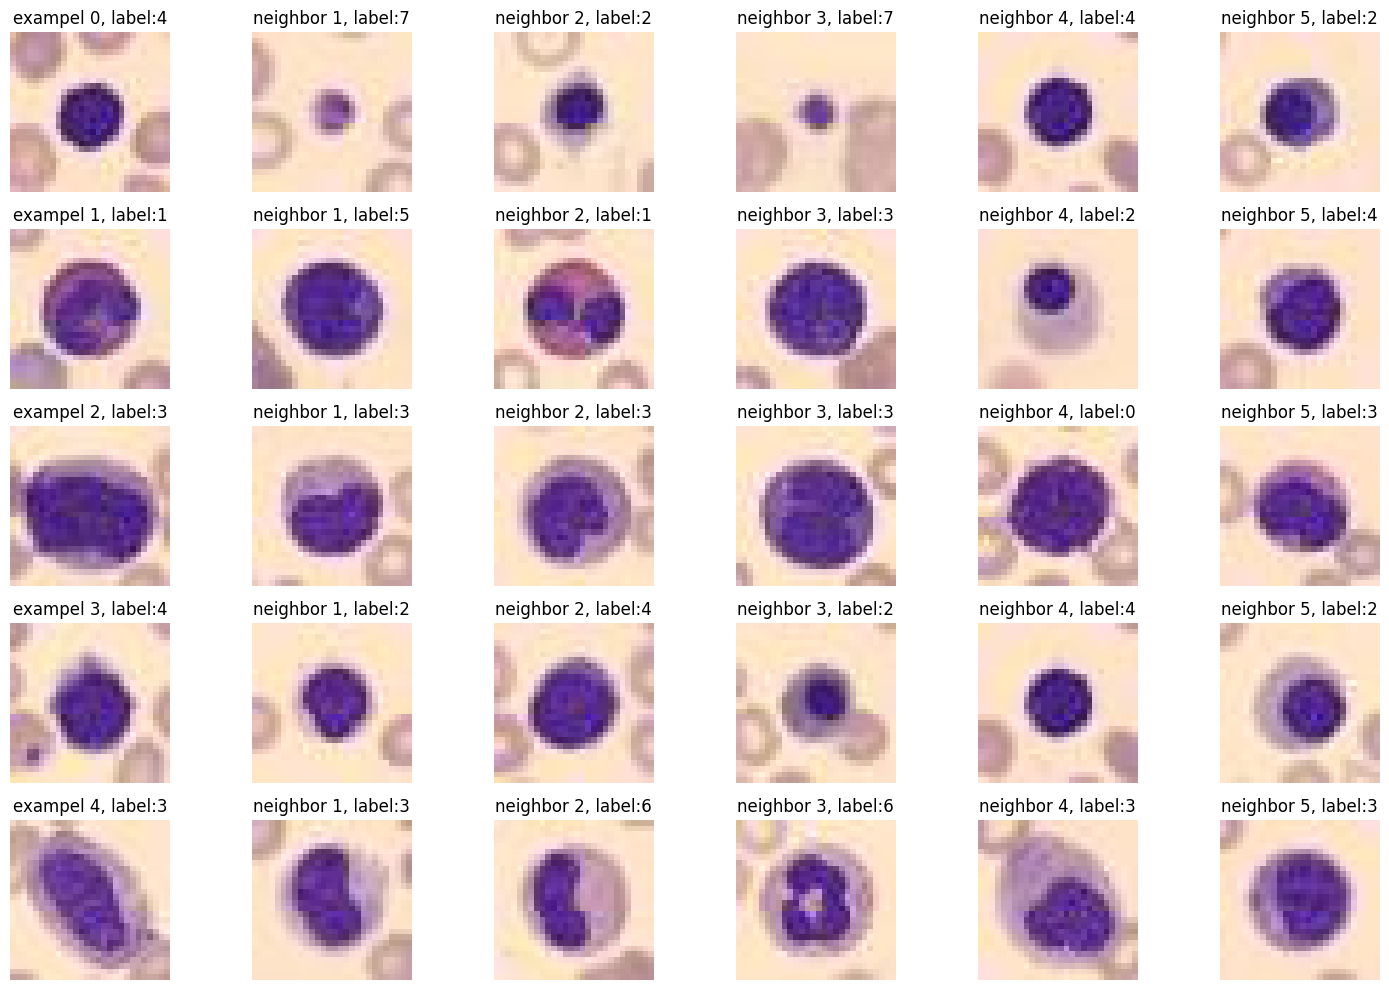

##Optimering af modellen (Hyperparameter tuning)
Vi er nu nået der til hvor vi har vores model, og skal til finde den bedste konfiguration. Nearest neighbor algoritmen er en non-parametrisk model så den kan i virkeligheden ikke "lære" noget. Vi kan dog optimere den vha. af hyperparameter "tuning". Det er i bund og grund en metode til at finde den bedste "indstilling" ved simpelthen at prøve sig frem. For nearest neighbor algoritmen er der to hyperparametre vi kan stille på:

*   Afstandsfunktionen (L1/L2)
*   Antallet af naboer (K)

Datasættet er allerede indelt i seperate trænings-, valideringsæt. Når man har fundet den bedste konfiguration ud fra valideringssættet vil man så teste den på et seperat testsæt.

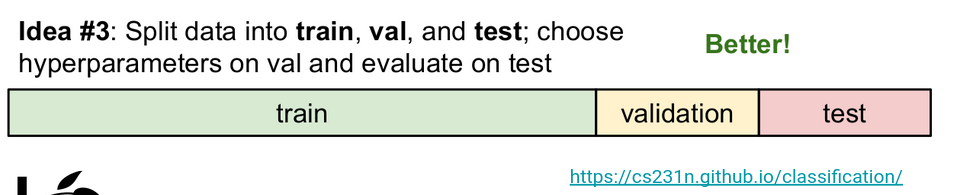



#Tip!
Tuning tager lang tid med mange værdier e.g.

neighbors = [1,3,5,7,13,21,33,45,55,67,79,91,111,131,149,167,193,201]

prøv derfor først med få værdier med større spredning og inskrænk derefter søgningen

Søg efter den optimale værdi for k (og evt. afstandsmetrik) ved at loope over værdier som denfor.



    knn = KNearestNeighbor()

    knn.train(X_train,y_train)


    neighbors = [1,5,13,33,67,79,91,131,167,201]


    for k_n in neighbors:
      predictions,_ = knn.predict(X_val,k=k_n)
      num_correct = sum(predictions==y_val)

      k_accuracy = (num_correct/y_val.shape[0])*100


In [ ]:
###############################
###Hyperparameter tuning her###
###############################

Gem resultaterne af hyperparameter søgningen ovenfor og plot som lignende nedenfor.

(fra min implementering)

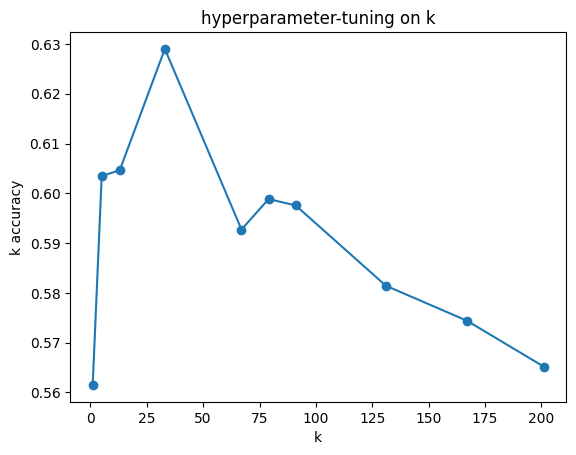

#Test modellen
Modellen er nu optimeret ud fra trænings- og valideringsættet. Og er klar til at blive prøvet af på testsættet som importeres som nedenfor.


    testDataset = BloodMNIST(split="test", download=True,size=28)
    X_test,y_test = testDataset.__dict__['imgs'],valDataset.__dict__['labels']
    print('Testsdata:')
    print(f'Billeder: {X_test.shape}, Labels: {y_test.shape}')
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    y_test = y_test.flatten()

    print(X_test.shape,y_test.shape)

In [ ]:
#############################################################################
###### test modellen på testsæt med optimal værdi a k fundet i tuning########
#############################################################################

#Note
Det er muligt at colab crasher hvis i tester på hele testsættet på en gang. Så det skal nok maskes/subsamples ligesom det blev gjort for validerings- og træningssættet i starten.

Netop fordi vi har subsamplet vores data er det ikke sikkert det er den optimale værdi vi har fundet for k (eller afstandsmetik), da vi har gjort datasættet en hel del mindre, hvilket sjældent leder til bedre modeller. Det er ikke sikkert at colab kan håndtere det fulde datasæt, men prøv at øge størrelsen og til den grænse det kan lade sig gøre og se hvordan det påvirker resultatet.

#Sådan!
Resultaterne af denne opgave afrapporteres i 1. portefølje opgave sammen med resultater for assignment 1.2 og 1.3